### Gene Ontology (GO), Fisher's exact test (FET), and Position Weight Matrices (PWMs)

In [1]:
from sequence import *
from prob import *

### Exercise 1 : Build a PWM for the Abf1 transcription factor

In [2]:
distribs = readMultiCount('abf1.jaspar')
distribs

In [3]:
abf1_pwm = PWM(distribs)
abf1_pwm.display()

 	     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
A	 -0.82 -25.33 -25.33 -25.33  +0.49  -0.13  +0.44  +0.31  +0.47  +0.51  -0.74 -25.33  +1.30 -25.33  +0.39  +0.31
C	 +0.49  +1.38 -25.33 -25.33  -0.39  -0.04  -0.45  -0.33  -0.17 -25.33  -0.01 -25.33  -1.14  +0.59  -0.13  -0.33
G	 -1.83 -25.33  +1.39 -25.33  -0.13  +0.04  +0.11  -0.22  -0.04  +0.84  -1.03  +1.18 -25.33  -1.02  -0.33  -0.58
T	 +0.57  -3.22 -25.33  +1.39  -0.22  +0.11  -0.39  +0.11  -0.51 -25.33  +0.78  -0.27 -25.33  +0.61  -0.08  +0.31


### Exercise 2: Select yeast promoter sequences for motif identification

In [4]:
# read fasta file
yeast_promoters = readFastaFile('yeast_promoters.fa')
len(yeast_promoters)

5850

In [5]:
shorest = 1000
shortest_promoter = ''
for seq in yeast_promoters:
    if len(seq) < shorest:
        shortest_promoter = seq
        shorest = len(seq)
print(shortest_promoter, "with length", shorest)

HIR1: TAAC with length 4


In [6]:
count = 0
filtered_yeast_promoters = []
for seq in yeast_promoters:
    if len(seq) >= 16:
        count += 1
        filtered_yeast_promoters.append(seq)
print(count)

5839


### Exercise 3 : Search for ABf1 binding sites and their target genes

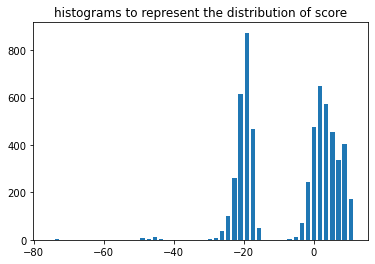

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# a set of yeast promoter sequences to search (filtered in Exericse 2)
yeast_promoters = filtered_yeast_promoters

distribs = readMultiCount("abf1.jaspar")
abf1_pwm = PWM(distribs)

score_dict = {}
for s in yeast_promoters: # yeast_prom is an array of sequences
    score_dict[s.name] = abf1_pwm.maxscore(s)[0] # save score only

# #Create a list of all scores
# scores = []
# for s in score_dict.keys():
#     if score_dict[s] != None:
#         scores.append(score_dict[s])

scores = list(score_dict.values()) #score_dict = the name of your dictiona

hist, bins = np.histogram(scores, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("histograms to represent the distribution of score")
    
plt.show()

### Exercise 4 : Perform Gene Ontology (GO) enrichment tests on target genes

In [8]:
#E4
pos500 = []
for gn in score_dict.keys():
    if score_dict[gn] > 8.33:
        pos500.append(gn)
print(len(pos500))

502


#### Step 1 : Generate a negative gene list from an instance of the GO class from godata.py

In [9]:
from godata import GO
positive_gene_list = pos500
go = GO("gene_association.sgd", "goslim_yeast.obo", (2,2,3,4,6,8))
negative_gene_list = list(go.getAllBackground(positive_gene_list)[0])[:1000]

('Started at', 'Thu May 27 15:04:46 2021')
Read 167 GO definitions
Read annotations for 6448 genes


#### Step 2 : Produce two dictionaries of data (one positive and one negative) with GO terms as the keys and the counts of how many genes are annotated with this GO term as the values.

In [10]:
# create a dic that stores how many (positive) genes have a specific G0: {GO: cnt_of_genes}
gos = go.getTerms4Genes(pos500)
gos_dic = {}
for k, value in gos.items():
    for i in value:
        try:
            gos_dic[i] += 1
        except:
            gos_dic[i] = 1
# create a dic that stores how many (negative) genes have a specific GO: {GO:cnt_of_genes}
neg_gos = go.getTerms4Genes(negative_gene_list)
neg_gos_dic = {}
for k, value in neg_gos.items():
    for i in value:
        try:
            neg_gos_dic[i] += 1
        except:
            neg_gos_dic[i] = 1

#### Step 3 : Perform a FET and Bonferroni correction for each of the GO terms stored in the positive and negative dictionaries.
- A = The number of genes in your positive gene list (genes believed to be regulated by Abf1) which were annotated with the target GO term.
- B = The number of genes in your positive gene list (genes believed to be regulated by Abf1) which were not annotated with the target GO term.
- C = The number of genes in your negative gene list (random sample of yeast genes) which were annotated with the target GO term.
- D = The number of genes in your negative gene list (random sample of yeast genes) which were not annotated with the target GO term

#### Step 4 : Identify GO terms that are over-represented in the Abf1 candidate gene set

In [11]:
# fisher's test
from stats import *
result = []
for i in gos_dic.keys():
    A = gos_dic[i]
    B = 500 - gos_dic[i]
    try:
        C = neg_gos_dic[i]
    except:
        C = 0
    D = len(negative_gene_list) - C
    p = getFETpval(A, B, C, D)
    e = p * len(gos_dic)
    if e < 50:
        result.append(i)
print(','.join(result))

GO:0008152,GO:0016021,GO:0003674,GO:0008150,GO:0006414,GO:0055114,GO:0016491,GO:0007059


Find an appropriate scoring threshold that will identify the top ~500 highest scoring genes in your dictionary and then compile their gene names in a list.

#### Question 5 : Do any of your enriched GO terms support a known role you've discovered Abf1 to play in *Saccharomyces cerevisiae?*

In [13]:
# go more information by getTermdef
for term in result:
    defin = go.getTermdef(term)
    print(defin)

('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('F', set(), 'molecular_function')
('P', set(), 'biological_process')
('P', {('GO:0008150', 'part_of'), ('GO:0008150', 'is_a')}, 'translational elongation')
('Unknown', 'Unknown', 'Unknown')
('F', {('GO:0003674', 'is_a'), ('GO:0008150', 'part_of')}, 'oxidoreductase activity')
('P', {('GO:0008150', 'is_a')}, 'chromosome segregation')
